# Guía 1 - Grupo 2
### Matías Bergerman, Pablo González Leiro, Tobias Demeco, Matías Tripoli

In [2]:
# Import modules
from PIL import Image
import numpy as np

## Pregunta 1

## Pregunta 2

![Imagen](https://scientificimaging.com/wp-content/uploads/2021/01/lens-WD-focal-length-AFOV-and-FOV-1-1024x576.png)

* Por simetría de triángulos, un triángulo isósceles de $10\ mm$ de base y $35\ mm$ de altura es semejante a uno de $1000\ mm$ de altura y $285.714\ mm$ de base.
* Dividiendo esta longitud por la cantidad de pixeles por linea (1000px) nos da una longitud por pixel del objeto igual a $0.285714\ mm$

## Pregunta 3

![Imagen](img/iso-rag-con_tripode.jpg)

## Pregunta 4

Para poder visualizar las imágenes con mayor facilidad, ambos cuadrados se muestran adyacentes unos a los otros y se usa un escalamiento x20 con el algoritmo *nearest neighbours*.

En cada caso se eligen diferentes colores de contorno y los puntos centrales se ajustaron hasta que perceptualmente se vean iguales, a pesar de que tengan un valor absoluto distinto.

Como conclusión, podemos ver que el contexto en el cual se perciba el color de cada pixel afecta la percepción de los mismos. Como seres humanos, nuestra visión se adapta a cada contexto y compensa automáticamente la percepción subjetiva de los colores de forma subconsciente e inevitable.

Colores de contorno: 63, 223
Colores del punto central: 100, 150


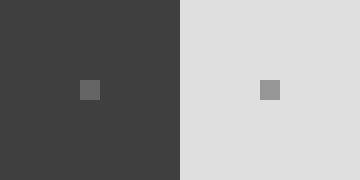

Colores de contorno: 0, 255
Colores del punto central: 100, 150


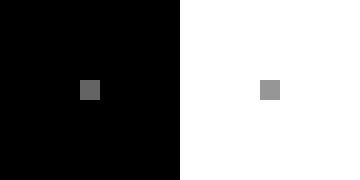

Colores de contorno: 150, 250
Colores del punto central: 100, 150


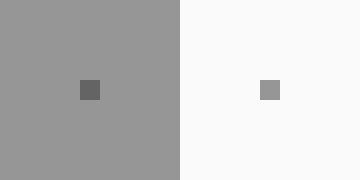

Colores de contorno: 20, 120
Colores del punto central: 120, 140


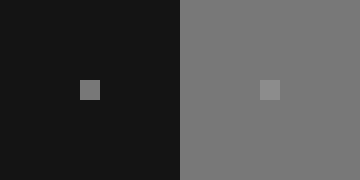

In [3]:
def make_squares(color_out_1, color_out_2, color_in_1, color_in_2, size=(9, 9)):
    c0, c1 = size[0]//2, size[1]//2
    a = np.full(size, color_out_1)
    a[c0, c1] = color_in_1
    b = np.full(size, color_out_2)
    b[c0, c1] = color_in_2
    joined_image = np.concatenate((a, b), axis=1)
    im = Image.fromarray(joined_image.astype(np.uint8), mode="L")
    return im

scale = 20

print("Colores de contorno: 63, 223\nColores del punto central: 100, 150")
im = make_squares(63, 223, 100, 150)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

print("Colores de contorno: 0, 255\nColores del punto central: 100, 150")
im = make_squares(0, 255, 100, 150)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

print("Colores de contorno: 150, 250\nColores del punto central: 100, 150")
im = make_squares(150, 250, 100, 150)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

print("Colores de contorno: 20, 120\nColores del punto central: 120, 140")
im = make_squares(20, 120, 120, 140)
display(im.resize(np.array(im.size)*scale, Image.Resampling.NEAREST))

## Pregunta 5

En este caso también se realiza un escalamiento a 256x256 pixeles con el algoritmo *nearest neighbours* para poder visualizar mejor los resultados.

Se puede ver que hay una imagen de Daniel Jacoby superpuesta con la imagen original.

El caso de promediar los pixeles de cada bloque no sólo remueve la presencia de esta imagen superpuesta, sino que además es la que perceptualmente mejor calidad obtiene entre los diferentes esquemas de submuestreo.

Imagen original de 256px x 256px


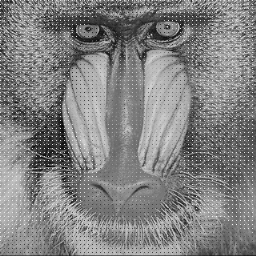

Imagen formada por el pixel (0,0) de cada bloque de 4x4


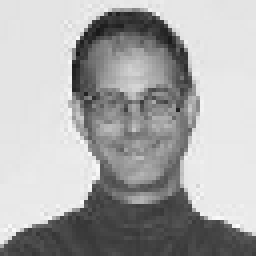

Imagen formada por el pixel (1,1) de cada bloque de 4x4


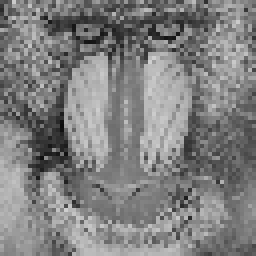

Imagen formada por el pixel (2,2) de cada bloque de 4x4


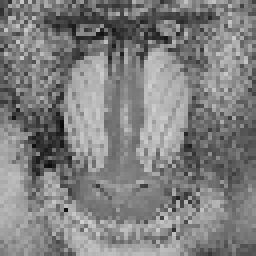

Imagen formada por promedio de cada bloque de 4x4


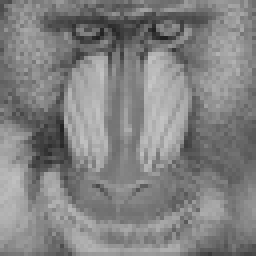

In [4]:
with Image.open("mono.bmp") as im:
    arr = np.asarray(im)
    M = 4
    blocks = [arr[x:x+M, y:y+M] for x in range(0,arr.shape[0],M) for y in range(0,arr.shape[1],M)]

blocks00 = [block[0,0] for block in blocks]
arr00 = np.asarray(blocks00).reshape(64,64)
im00 = Image.fromarray(arr00, mode="L").resize((256,256), Image.Resampling.NEAREST)

blocks11 = [block[1,1] for block in blocks]
arr11 = np.asarray(blocks11).reshape(64,64)
im11 = Image.fromarray(arr11, mode="L").resize((256,256), Image.Resampling.NEAREST)

blocks22 = [block[2,2] for block in blocks]
arr22 = np.asarray(blocks22).reshape(64,64)
im22 = Image.fromarray(arr22, mode="L").resize((256,256), Image.Resampling.NEAREST)

blocks_avg = [np.average(block) for block in blocks]
arr_avg = np.asarray(blocks_avg).astype(np.uint8).reshape(64,64)
im_avg = Image.fromarray(arr_avg, mode="L").resize((256,256), Image.Resampling.NEAREST)

print("Imagen original de 256px x 256px")
display(im)
print("Imagen formada por el pixel (0,0) de cada bloque de 4x4")
display(im00)
print("Imagen formada por el pixel (1,1) de cada bloque de 4x4")
display(im11)
print("Imagen formada por el pixel (2,2) de cada bloque de 4x4")
display(im22)
print("Imagen formada por promedio de cada bloque de 4x4")
display(im_avg)

### Implementación de la interpolación bicúbica

Basado en:
* R. Keys (1981). "Cubic convolution interpolation for digital image processing". IEEE Transactions on Acoustics, Speech, and Signal Processing. 29 (6): 1153–1160.
* https://www.geeksforgeeks.org/python-opencv-bicubic-interpolation-for-resizing-image/

In [10]:
# Kernel de interpolación
def u(s, a):
    abs_s = abs(s)
    if abs_s <= 1:
        return (a+2) * abs_s**3 - (a+3) * abs_s**2 + 1
    elif abs_s <= 2:
        return a * abs_s**3 - (5*a) * abs_s**2 + (8*a)*abs_s - 4*a
    else:
        return 0

# Padding
def padding(img, H, W, C):
    # Creamos una nueva matrix con 2 filas y 2 columnas extra a cada lado
    img_pad = np.zeros((H+4, W+4, C))
    img_pad[2:H+2, 2:W+2, :C] = img
      
    # Paddear las primeras y ultimas 2 columnas copiando los bordes
    img_pad[2:H+2, 0:2, :C] = img[:, 0:1, :C]
    img_pad[H+2:H+4, 2:W+2, :C] = img[H-1:H, :, :C]
    img_pad[2:H+2, W+2:W+4, :C] = img[:, W-1:W, :C]
    img_pad[0:2, 2:W+2, :C] = img[0:1, :, :C]
      
    # Paddear los puntos en las esquinas
    img_pad[0:2, 0:2, :C] = img[0, 0, :C]
    img_pad[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
    img_pad[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
    img_pad[0:2, W+2:W+4, :C] = img[0, W-1, :C]

    return img_pad

# Interpolacion bicubica
def bicubic(img, ratio, a):

    # Obtener el tamaño de la imagen
    H, W = img.shape[0:2]
    C = 1 if img.ndim < 3 else img.shape[2]
    img = img.reshape((H, W, C))  # Esto sólo tiene efecto cuando la imagen es bidimensional (blanco y negro)
      
    # H = Height, W = Width,
    # C = Número de colores
    img = padding(img, H, W, C)
      
    # Create new image
    new_H = np.floor(H*ratio).astype(int)
    new_W = np.floor(W*ratio).astype(int)
  
    # Crear una matriz resultado vacía
    new_img = np.zeros((new_H, new_W, C))  
  
    h = 1/ratio
      
    for c in range(C):
        for j in range(new_H):
            for i in range(new_W):
                
                # Coordenadas de valores vecinos
                x, y = i * h + 2, j * h + 2
  
                x1 = 1 + x - np.floor(x)
                x2 = x - np.floor(x)
                x3 = np.floor(x) + 1 - x
                x4 = np.floor(x) + 2 - x
  
                y1 = 1 + y - np.floor(y)
                y2 = y - np.floor(y)
                y3 = np.floor(y) + 1 - y
                y4 = np.floor(y) + 2 - y
                  
                mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
                mat_m = np.matrix([[img[int(y-y1), int(x-x1), c],
                                    img[int(y-y2), int(x-x1), c],
                                    img[int(y+y3), int(x-x1), c],
                                    img[int(y+y4), int(x-x1), c]],
                                   [img[int(y-y1), int(x-x2), c],
                                    img[int(y-y2), int(x-x2), c],
                                    img[int(y+y3), int(x-x2), c],
                                    img[int(y+y4), int(x-x2), c]],
                                   [img[int(y-y1), int(x+x3), c],
                                    img[int(y-y2), int(x+x3), c],
                                    img[int(y+y3), int(x+x3), c],
                                    img[int(y+y4), int(x+x3), c]],
                                   [img[int(y-y1), int(x+x4), c],
                                    img[int(y-y2), int(x+x4), c],
                                    img[int(y+y3), int(x+x4), c],
                                    img[int(y+y4), int(x+x4), c]]])
                mat_r = np.matrix(
                    [[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
                  
                # Producto punto de las dos matrices
                new_img[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)
  
    return new_img

Imagen original


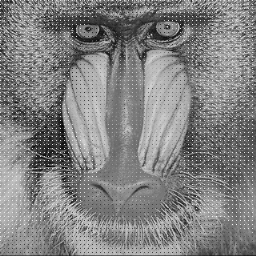

Imagen formada por el pixel (0,0) de cada bloque de 4x4 (escalada mediante Nearest Neighbours)


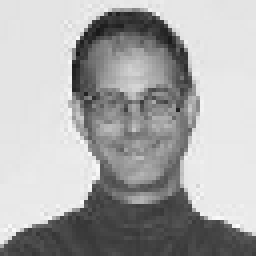

Imagen formada por el pixel (0,0) de cada bloque de 4x4 (escalada mediante Interpolación Bilineal)
Imagen formada por el pixel (0,0) de cada bloque de 4x4 (escalada mediante Interpolación Bicúbica)


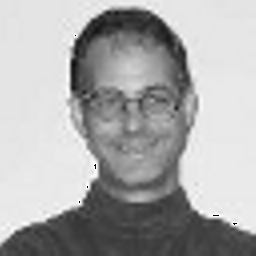

Imagen formada por el pixel (1,1) de cada bloque de 4x4 (escalada mediante Nearest Neighbours)


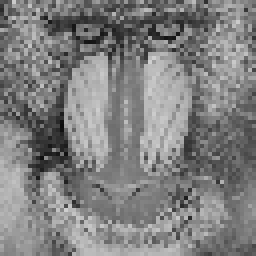

Imagen formada por el pixel (1,1) de cada bloque de 4x4 (escalada mediante Interpolación Bilineal)
Imagen formada por el pixel (1,1) de cada bloque de 4x4 (escalada mediante Interpolación Bicúbica)


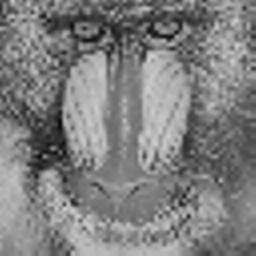

Imagen formada por promedio de cada bloque de 4x4 (escalada mediante Nearest Neighbours)


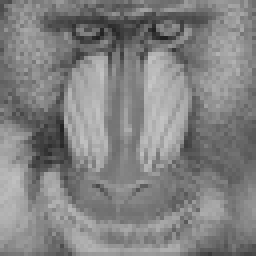

Imagen formada por promedio de cada bloque de 4x4 (escalada mediante Interpolación Bilineal)
Imagen formada por promedio de cada bloque de 4x4 (escalada mediante Interpolación Bicúbica)


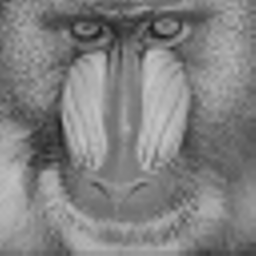

In [11]:
# Factor de escala
ratio = 4

# Coeficiente de interpolación bicubica (típicamente -0.5 o -0.75)
a = -1/2
  
arr00_bicubic = bicubic(arr00, ratio, a).reshape(64*ratio, 64*ratio)
arr11_bicubic = bicubic(arr11, ratio, a).reshape(64*ratio, 64*ratio)
arr_avg_bicubic = bicubic(arr_avg, ratio, a).reshape(64*ratio, 64*ratio)

print("Imagen original")
display(im)

print("Imagen formada por el pixel (0,0) de cada bloque de 4x4 (escalada mediante Nearest Neighbours)")
display(im00)
print("Imagen formada por el pixel (0,0) de cada bloque de 4x4 (escalada mediante Interpolación Bilineal)")
#display(Image.fromarray(arr_bilinear.astype(np.uint8)))
print("Imagen formada por el pixel (0,0) de cada bloque de 4x4 (escalada mediante Interpolación Bicúbica)")
display(Image.fromarray(arr00_bicubic.astype(np.uint8)))

print("Imagen formada por el pixel (1,1) de cada bloque de 4x4 (escalada mediante Nearest Neighbours)")
display(im11)
print("Imagen formada por el pixel (1,1) de cada bloque de 4x4 (escalada mediante Interpolación Bilineal)")
#display(Image.fromarray(arr_bilinear.astype(np.uint8)))
print("Imagen formada por el pixel (1,1) de cada bloque de 4x4 (escalada mediante Interpolación Bicúbica)")
display(Image.fromarray(arr11_bicubic.astype(np.uint8)))

print("Imagen formada por promedio de cada bloque de 4x4 (escalada mediante Nearest Neighbours)")
display(im_avg)
print("Imagen formada por promedio de cada bloque de 4x4 (escalada mediante Interpolación Bilineal)")
#display(Image.fromarray(arr_bilinear.astype(np.uint8)))
print("Imagen formada por promedio de cada bloque de 4x4 (escalada mediante Interpolación Bicúbica)")
display(Image.fromarray(arr_avg_bicubic.astype(np.uint8)))